# **UBIT: 50610509 Name: Keshav Narayan Srinivasan**

In [193]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [194]:
file_path = "Data.csv"
df = pd.read_csv(file_path)

In [195]:

# 1) Handle missing values in essential columns 
df_cleaned = df.dropna(subset=['latitude', 'popular_times', 'longitude', 'rating'])

# 2) Converting Cities and States to a unified format
df_cleaned['city'] = df_cleaned['city'].str.lower()
df_cleaned['us_state'] = df_cleaned['us_state'].str.lower()
df_cleaned['city'] = df_cleaned['city'].str.capitalize()
df_cleaned['us_state'] = df_cleaned['us_state'].str.capitalize()

# #3) Normalizing the working hours for time consistent format
df_cleaned['working_hours'] = df_cleaned['working_hours'].astype(str)
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[a-zA-Z\s]+', '', x))
df_cleaned['working_hours'] = df_cleaned['working_hours'].fillna('Unknown')

# Function to calculate weekday hours from the 'working_hours' column
def get_weekday_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekday hours (Monday to Friday are typically the first 5 sections)
        weekday_parts = parts[1:6]
        # Count non-empty time ranges in the first 5 parts
        weekday_hours = sum(1 for part in weekday_parts if part.strip())
        return weekday_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Function to calculate weekend hours from the 'working_hours' column
def get_weekend_hours(working_hours):
    try:
        # Split the string by colons
        parts = working_hours.split(':')
        # Extract weekend hours (Saturday and Sunday are typically the 6th and 7th sections)
        weekend_parts = parts[5:7]
        # Count non-empty time ranges in the 6th and 7th parts
        weekend_hours = sum(1 for part in weekend_parts if part.strip())
        return weekend_hours
    except Exception as e:
        return 0  # Default to 0 if there's an error

# Apply the functions to the 'working_hours' column to calculate weekday and weekend hours
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)

# 4) Making the names uniform by applying title case
df_cleaned['name'] = df_cleaned['name'].str.title()

# 5) Removing invalid latitude and longitude range and bringing precision to them
df_cleaned = df_cleaned[(df_cleaned['latitude'].between(-90, 90)) & (df_cleaned['longitude'].between(-180, 180))]
df_cleaned['latitude'] = df_cleaned['latitude'].round(6)
df_cleaned['longitude'] = df_cleaned['longitude'].round(6)

# 6) Creating a new column 'rating_category' based on 'rating' (with tiers as low, medium, high)
df_cleaned['rating_category'] = pd.cut(df_cleaned['rating'], bins=[0, 3, 4.5, 5], labels=['Low', 'Medium', 'High'])

# 7) Removing the whitespace from following columns
df_cleaned['name'] = df_cleaned['name'].str.strip()
df_cleaned['city'] = df_cleaned['city'].str.strip()

# 8) Introducing a new column 'is_weekend_open' based on 'working_hours' to check if locations are open on weekends
def has_values_after_colon(working_hours):
    try:
        # Split the string by colon and check if there are values after the 6th and 7th positions
        parts = working_hours.split(':')
        if len(parts) > 6 and parts[6].strip():  # Check 7th part exists and is not empty
            return True  # There's a value after the 6th colon
        if len(parts) > 7 and parts[7].strip():  # Check 8th part exists and is not empty
            return True  # There's a value after the 7th colon
        return False
    except Exception as e:
        # In case of any issue, return False
        return False

# Apply the function to detect if there are values after the 6th and 7th colons
df_cleaned['is_weekend_open'] = df_cleaned['working_hours'].apply(has_values_after_colon)

# 9) Convertings 'rating' column to numeric data if any inconsitency
df_cleaned['rating'] = pd.to_numeric(df_cleaned['rating'], errors='coerce')
df_cleaned = df_cleaned.dropna(subset=['rating'])

# 10) Creating columns 'weekday_hours'and 'weekend_hours'
df_cleaned['working_hours'] = df_cleaned['working_hours'].apply(lambda x: re.sub(r'[^\d:-]', '', x))
df_cleaned['weekday_hours'] = df_cleaned['working_hours'].apply(get_weekday_hours)
df_cleaned['weekend_hours'] = df_cleaned['working_hours'].apply(get_weekend_hours)
# 11 Standardize the 'rating' column by scaling it to a range of 0 to 5
df_cleaned['rating_scaled'] = (df_cleaned['rating'] / df_cleaned['rating'].max()) * 5
df_cleaned['popular_times'] = df_cleaned['popular_times'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df_cleaned = df_cleaned[df_cleaned['popular_times'].apply(lambda x: isinstance(x, list) and len(x) == 7)]

df_cleaned.to_csv("C:\\Users\\kesha\\OneDrive\\UB\\Fall 2024\\Data Intensive Computing\\Project\\Data_5.csv")

# Explanation and Analysis
# **Problem 1. Prediction of Crowd density using Gradient Boosting Regressor**

**Relevance**: The aim of this problem is to predict crowd density based on factors like operational hours, ratings, and popularity scores. Gradient Boosting seemed to be a good choice for such structured data because after looking into it gave high predictive power, especially in cases where complex interactions between features influence the target variable. This seemed to be different in Random Forest and SVR.

I found that Gradient Boosting was good at creating multiple trees sequentially, focusing on reducing errors from previous trees. So the capture of complex patterns in crowd density influenced by multiple features seemed to be done correctly, which is essential given the multifactorial nature of crowding levels.

**Tuning and Training**:

**Parameter Tuning**: We experimented with several parameters, particularly focusing on:

n_estimators: Increased to 200 to allow for sufficient boosting steps while keeping the model from overfitting.

learning_rate: Set to 0.05, trying to balance between model accuracy and convergence speed, as a lower rate helps avoid 
large jumps that might make training unstable.

max_depth: Limited to 4 to prevent overfitting, ensuring each tree captured interactions without excessive noise.
Additional features such as the log scaling of crowd density were done to find variations in crowding more accurately, especially as raw density values tended to cluster closely.

**Effectiveness of the model**

Gradient Boosting has seemed to be a solid fit to the data, with a satisfactory Mean Absolute Percentage Error (MAPE) after tuning. This demonstrated its effectiveness in capturing certain patterns in crowd density based on the provided features.

**Metrics Used**

R²: Indicative of the proportion of variance explained by the model.

MAPE: Provided a measure of average prediction error in percentage terms.

Precision (Standard Deviation of Errors): Helped understand the consistency of predictions.

Finally, the model’s predictions on crowd density provided insights into how various features affect crowd levels. For example, locations with longer hours or higher ratings tended to lean towards higher predicted crowd densities. This can be helpful during resource planning, as the model’s output allows for anticipation of crowding trends based on known attributes. It provided reliable predictions of crowd density, demonstrating the relationships between location attributes and crowd levels. Its ability to capture complex patterns helped to estimate crowding accurately, helping in strategic decision-making.



In [204]:
results = []

for idx, row in df_cleaned.iterrows():
    popular_times = row['popular_times']  
    df = pd.DataFrame(popular_times, index=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
    df.columns = [f'{hour:02d}:00' for hour in range(24)]
    

    daily_avg_popularity = df.mean(axis=1)
    busiest_hours = df.idxmax(axis=1)
    overall_avg_popularity = df.values.mean()
    weekday_popularity = df.loc['Monday':'Friday'].mean().mean()
    weekend_popularity = df.loc[['Saturday', 'Sunday']].mean().mean()
    weekday_weekend_ratio = weekday_popularity / weekend_popularity if weekend_popularity else 100 


    results.append({
        'name': row['name'],
        'daily_avg_popularity': daily_avg_popularity.tolist(),
        'busiest_hours': busiest_hours.tolist(),
        'overall_avg_popularity': overall_avg_popularity,
        'weekday_weekend_ratio': weekday_weekend_ratio
    })

results_df = pd.DataFrame(results)

df_cleaned = df_cleaned.merge(
    results_df[['name', 'daily_avg_popularity', 'busiest_hours', 'overall_avg_popularity', 'weekday_weekend_ratio']], 
    on='name'
)

print("Updated DataFrame with Popularity Metrics:")
print(df_cleaned.head())
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

df_cleaned['crowding_index'] = df_cleaned['overall_avg_popularity']

features = ['latitude', 'longitude', 'weekday_hours', 'weekend_hours', 'rating_scaled', 'weekday_weekend_ratio']

df_cleaned['peak_popularity'] = df_cleaned['daily_avg_popularity'].apply(lambda x: max(eval(x)) if isinstance(x, str) else 0)
df_cleaned['off_peak_avg'] = df_cleaned['daily_avg_popularity'].apply(lambda x: np.mean([p for p in eval(x) if p < max(eval(x))]) if isinstance(x, str) else 0)
df_cleaned['popularity_std_dev'] = df_cleaned['daily_avg_popularity'].apply(lambda x: np.std(eval(x)) if isinstance(x, str) else 0)
df_cleaned['total_weekly_hours'] = df_cleaned['weekday_hours'] * 5 + df_cleaned['weekend_hours'] * 2

engineered_features = features + ['peak_popularity', 'off_peak_avg', 'popularity_std_dev', 'total_weekly_hours']

X = df_cleaned[engineered_features]
y = df_cleaned['crowding_index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train_scaled, y_train)

y_pred = gb_model.predict(X_test_scaled)

mape = mean_absolute_percentage_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("MAPE:", mape)
print("Mean Absolute Accuracy:", 1 - mape)  
print("R-squared:", r2)
print("Mean Squared Error:", mse)

Updated DataFrame with Popularity Metrics:
   Unnamed: 0.1  Unnamed: 0                         name  \
0             0           0            Mardis Mill Falls   
1             1           1  Waterville Usa/Escape House   
2             2           2    Bama Bison Rv Park & Farm   
3             3           3            The Mobile Tunnel   
4             4           4                    Bamahenge   

                                       popular_times   latitude  longitude  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  34.044364 -86.571446   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.258331 -87.687064   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  32.425044 -85.250269   
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.690009 -88.035620   
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  30.331442 -87.567232   

                  working_hours          city us_state  rating  \
0  :6-7:6-7:6-7:6-7:6-7:6-7:6-7  Blountsville  Alabama     4.

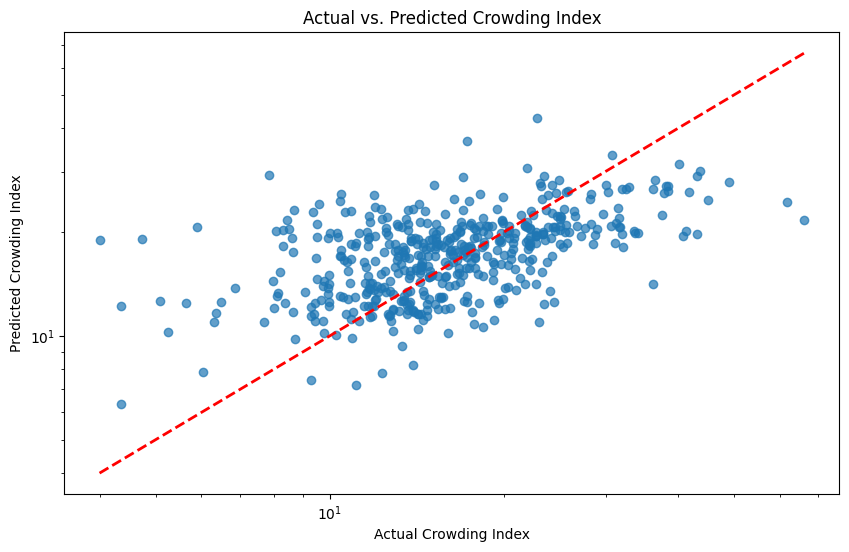

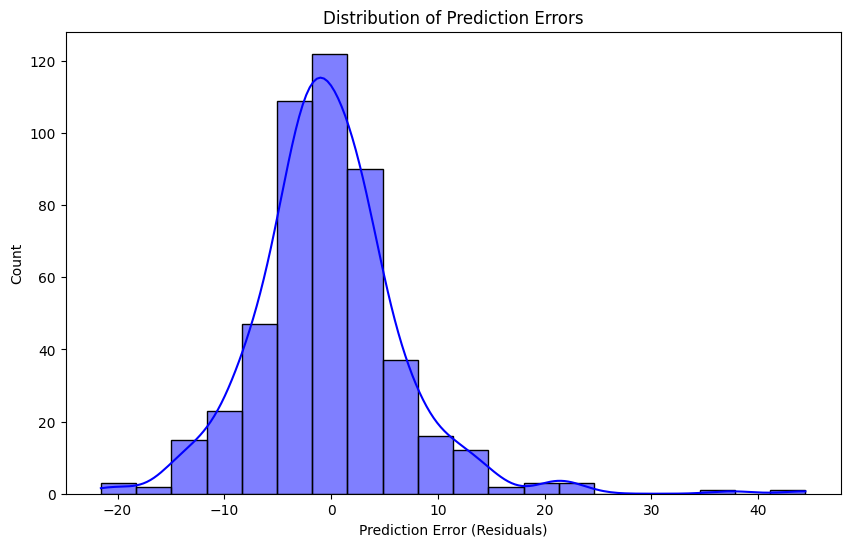

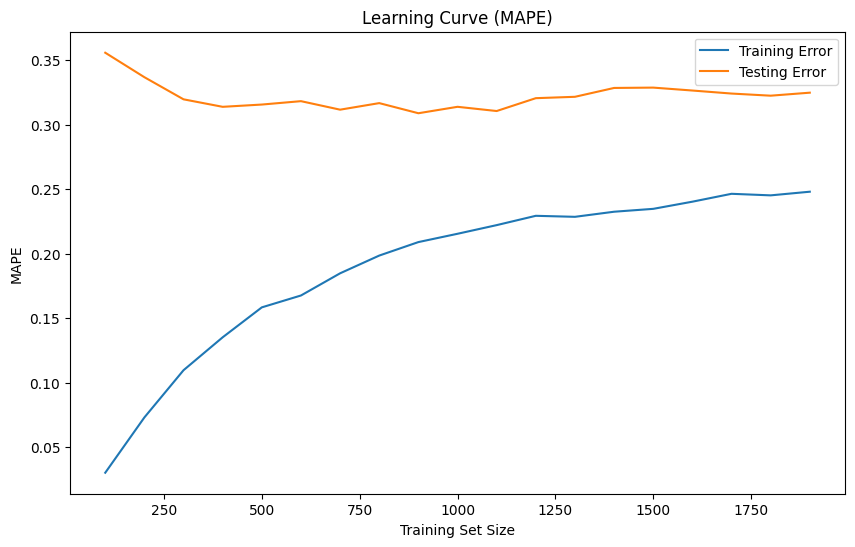

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error


errors = y_test - y_pred


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Actual Crowding Index')
plt.ylabel('Predicted Crowding Index')
plt.xscale('log')
plt.yscale('log')
plt.title('Actual vs. Predicted Crowding Index')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='blue', bins=20)
plt.xlabel('Prediction Error (Residuals)')
plt.title('Distribution of Prediction Errors')
plt.show()


train_errors, test_errors = [], []
interval = 100 


for m in range(interval, len(X_train_scaled), interval):
    gb_model.fit(X_train_scaled[:m], y_train[:m])
    y_train_predict = gb_model.predict(X_train_scaled[:m])
    y_test_predict = gb_model.predict(X_test_scaled)

    train_errors.append(mean_absolute_percentage_error(y_train[:m], y_train_predict))
    test_errors.append(mean_absolute_percentage_error(y_test, y_test_predict))


plt.figure(figsize=(10, 6))
plt.plot(range(interval, len(X_train_scaled), interval), train_errors, label="Training Error")
plt.plot(range(interval, len(X_train_scaled), interval), test_errors, label="Testing Error")
plt.xlabel("Training Set Size")
plt.ylabel("MAPE")
plt.title("Learning Curve (MAPE)")
plt.legend()
plt.show()

# Explanation and Analysis
# **Problem 2. Clustering Places based on Location and Crowding_Index using DBSCAN (Density based Spacial Clustering)**

**Relevance**
DBSCAN is particularly suitable for spatial clustering in this problem because it is well-suited for identifying clusters based on geographical proximity and density. This aligns with the problem's goal of identifying clusters of nearby tourist spots and recognizing less crowded spots as noise.

It has an inclusive mechanism for identifying "noise" points, which are locations that do not meet the minimum density requirements to be part of a cluster. This is crucial, as these isolated noise points are of interest as potential alternatives to more crowded spots.

Moreover, it’s ability to identify arbitrarily shaped clusters is advantageous in geographical data, where tourist spots might naturally form irregular clusters based on location and crowd density.

**Tuning and Training:**

**Parameter Tuning**: DBSCAN relies on two main parameters—eps (distance threshold for points to be considered neighbors) and min_samples (minimum number of points required to form a cluster). To determine appropriate values, we did:

eps: Experimented with various values based on the distance units in latitude and longitude coordinates. We chose a value that balanced the cluster formation and noise point detection.

min_samples: We tweaked this to ensure meaningful clusters were created without overly separating the data, eventually settling on a value that balanced cluster density and noise isolation.

And for normalization we made sure Latitude, longitude, and crowd density values were standardized, ensuring each feature contributed equally to clustering.

**Effectiveness**:

DBSCAN effectively grouped nearby spots into clusters and isolated low-density, less-visited points. The quantile-based color coding in the visualizations allowed for identification of high, medium, and low-density clusters.

By observing clusters and isolated points, we gained insights into potential alternative destinations. Noise points represent locations that are spatially distant from others, suggesting they might offer less crowded options for tourists. 

So I could say that we can support sustainable tourism by promoting lesser-known areas. Hence we effectively clustered nearby tourist spots and isolated less crowded locations as noise, aligning well with the objective of identifying potential alternatives to popular crowded destinations.


In [206]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import seaborn as sns
import folium
from folium.plugins import MarkerCluster


coordinates = df_cleaned[['latitude', 'longitude']]
crowd_density = df_cleaned['crowding_index']
features = np.column_stack((coordinates, crowd_density))
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

eps = 0.3
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
db_labels = db.fit_predict(features_scaled)

df_cleaned['cluster'] = db_labels

clustered_data = df_cleaned[df_cleaned['cluster'] != -1]

cluster_centers = clustered_data.groupby('cluster').agg({
    'latitude': 'mean',
    'longitude': 'mean',
    'crowding_index': 'mean'
}).reset_index()
cluster_centers['log_crowding_index'] = np.log(cluster_centers['crowding_index'] + 1e-10)

q_low = cluster_centers['log_crowding_index'].quantile(0.33)
q_high = cluster_centers['log_crowding_index'].quantile(0.55)

cluster_centers['color'] = cluster_centers['log_crowding_index'].apply(
    lambda x: 'red' if x > q_high else ('green' if x < q_low else 'orange')
)

map_center = [clustered_data['latitude'].mean(), clustered_data['longitude'].mean()]
map_folium = folium.Map(location=map_center, zoom_start=6)

for _, row in clustered_data.iterrows():
    cluster_num = row['cluster']
    color = cluster_centers.loc[cluster_centers['cluster'] == cluster_num, 'color'].values[0]
    
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        tooltip=f"Cluster: {cluster_num}, Log Crowd Density: {np.log(row['crowding_index'] + 1e-10):.2f}"
    ).add_to(map_folium)

for _, row in cluster_centers.iterrows():
    folium.Marker(
        location=(row['latitude'], row['longitude']),
        popup=f"Cluster {int(row['cluster'])} Center, Log Avg Density: {row['log_crowding_index']:.2f}",
        icon=folium.Icon(color=row['color'], icon="info-sign")
    ).add_to(map_folium)

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 200px; height: auto; 
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;">
    <h4>Cluster Density (Log, Quantile) Legend</h4>
    <div><span style="color:red;">&#9679;</span> High Density (Top 25%)</div>
    <div><span style="color:orange;">&#9679;</span> Medium Density (Middle 50%)</div>
    <div><span style="color:green;">&#9679;</span> Low Density (Bottom 25%)</div>
</div>
'''

map_folium.get_root().html.add_child(folium.Element(legend_html))

map_folium.save("Tourist_Clusters_Quantile_Log_Density_Legend.html")
map_folium

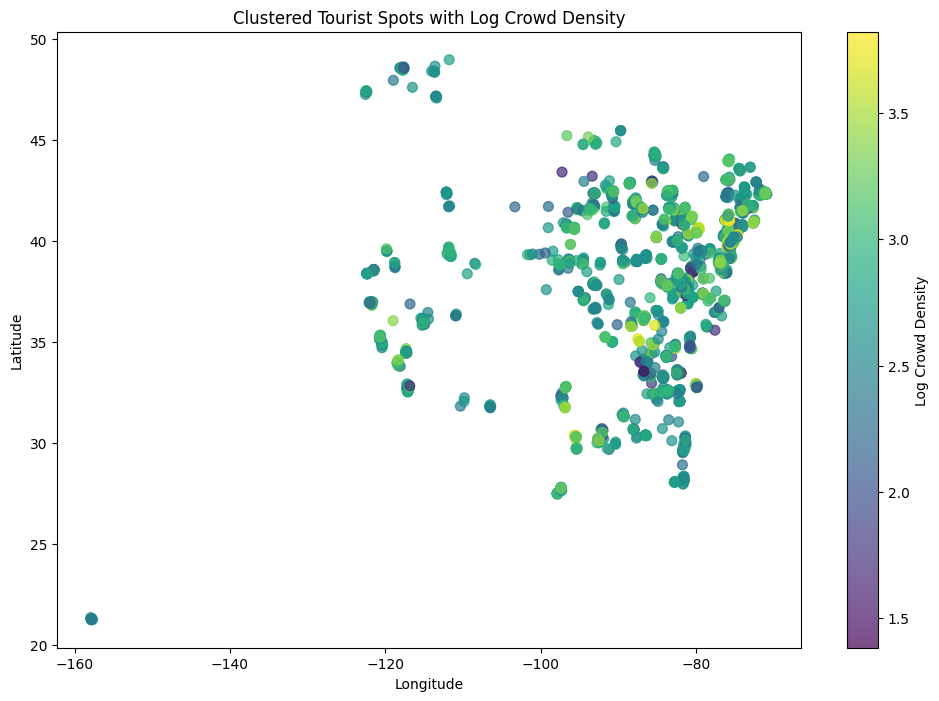

In [207]:

clustered_data = df_cleaned[df_cleaned['cluster'] != -1].copy()
clustered_data['log_crowding_index'] = np.log(clustered_data['crowding_index'] + 1e-10)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    clustered_data['longitude'], 
    clustered_data['latitude'], 
    c=clustered_data['log_crowding_index'], 
    cmap='viridis', 
    s=50, 
    alpha=0.7
)
plt.colorbar(scatter, label='Log Crowd Density')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Clustered Tourist Spots with Log Crowd Density')
plt.show()